In [1]:
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Verdana']
rcParams['font.size'] = 12
rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import phoebe
from matplotlib.ticker import FormatStrFormatter

cs = {'blue': '#2b71b1', 'orange': '#ff702f', 'green': '#22b77f', 'red': '#f92e3d', 'black': '#131313'}

In [29]:
def bundle_get_params_lc(filename, params_list, model_tag, true=False):
    b = phoebe.load('data/'+filename+'.bundle')
    if true:
        b.add_constraint('requivsumfrac')
        b.add_constraint('requivratio')
        b.add_constraint('teffratio')
        b.flip_constraint('teffratio', solve_for='teff@secondary')
        b.flip_constraint('requivsumfrac', solve_for='requiv@secondary')
        b.flip_constraint('requivratio', solve_for='requiv@primary')
        b.flip_constraint('esinw', solve_for='ecc')
        b.flip_constraint('ecosw', solve_for='per0')
        b.flip_constraint('q', solve_for='mass@secondary')
        
    params = {}
    
    for param in params_list:
        params[param] = b.get_value(param)
    
    phases = b.to_phase(b['times@dataset@lc01'])
    fluxes = b['value@fluxes@%s@lc01' % model_tag]
    s=np.argsort(phases)
    
    lc = np.array([phases[s], fluxes[s]]).T
    if true:
        chi2 = np.nan
    else:
        residuals = b.calculate_residuals(model=model_tag)
        sigmas = b.get_value('sigmas', dataset='lc01')
        chi2 = np.sum((residuals.value**2 / sigmas))

    return {'solution': params, 'lc': lc, 'chi2': chi2}

def compute_y(solution, true, param):
    return 100*np.abs((solution['solution'][param]-true['solution'][param])/(true['solution'][param]))


def bundle_get_params_cb(filename, params_list, model_tag, true=False):
    b = phoebe.load('data/'+filename+'.bundle')
    if true:
        b.flip_constraint('pot', solve_for='requiv@primary')
        b.flip_constraint('fillout_factor', solve_for='pot')
        b.add_constraint('teffratio')
        b.flip_constraint('teffratio', solve_for='teff@secondary')
        b.flip_constraint('q', solve_for='mass@secondary')
        
    params = {}
    
    for param in params_list:
        params[param] = b.get_value(param)
    
    phases = b.to_phase(b['times@dataset@lc01'])
    fluxes = b['value@fluxes@%s@lc01' % model_tag]
    s=np.argsort(phases)
    
    lc = np.array([phases[s], fluxes[s]]).T
    if true:
        chi2 = np.nan
    else:
        residuals = b.calculate_residuals(model=model_tag)
        sigmas = b.get_value('sigmas', dataset='lc01')
        chi2 = np.sum((residuals.value**2 / sigmas))
 
    return {'solution': params, 'lc': lc, 'chi2': chi2}

def plot_solution(ax, title, labels, params, true, nm_m2o, nm_m2s, nm_m2gs, cg_m2o, cg_m2s, cg_m2gs, mode='method', ylabel=False):
    
    s=50
    
    xs = np.arange(1, len(labels)+1, 1).astype(int)
    scatter_dict = {'x': [], 'y': [], 'fc': [], 'ec': [], 's': [], }

    for i,x in enumerate(xs):
        scatter_dict['x'] += [x, x, x, x, x, x]
        scatter_dict['fc'] += [cs['black'], cs['blue'], cs['red'], 'none', 'none', 'none']
        scatter_dict['ec'] += [cs['black'], cs['blue'], cs['red'], cs['black'], cs['blue'], cs['red']]
        scatter_dict['y'] += [compute_y(nm_m2o, true, params[i]),
                              compute_y(nm_m2s, true, params[i]),
                              compute_y(nm_m2gs, true, params[i]),
                              compute_y(cg_m2o, true, params[i]),
                              compute_y(cg_m2s, true, params[i]),
                              compute_y(cg_m2gs, true, params[i])]                     
        scatter_dict['s'] += [s*nm_m2o['chi2'],
                              s*nm_m2s['chi2'],
                              s*nm_m2gs['chi2'],
                              s*cg_m2o['chi2'],
                              s*cg_m2s['chi2'],
                              s*cg_m2gs['chi2']]
                              
        
        if mode == 'method':
            ax.scatter(scatter_dict['x'][0], scatter_dict['y'][0], marker='o', 
                   s=scatter_dict['s'][0], 
                   facecolors=scatter_dict['fc'][0],
                   edgecolors=scatter_dict['ec'][0], label='Nelder-Mead')
            ax.scatter(scatter_dict['x'][3], scatter_dict['y'][3], marker='o', 
                   s=scatter_dict['s'][3], 
                   facecolors=scatter_dict['fc'][3],
                   edgecolors=scatter_dict['ec'][3], label='conjugate gradient')
            
        if mode=='strategy':
            ax.scatter(scatter_dict['x'][0], scatter_dict['y'][0], marker='o', 
                   s=scatter_dict['s'][0], 
                   facecolors=scatter_dict['fc'][0],
                   edgecolors=scatter_dict['ec'][0], label='full')
            ax.scatter(scatter_dict['x'][1], scatter_dict['y'][1], marker='o', 
                   s=scatter_dict['s'][1], 
                   facecolors=scatter_dict['fc'][1],
                   edgecolors=scatter_dict['ec'][1], label='sequential')
            ax.scatter(scatter_dict['x'][2], scatter_dict['y'][2], marker='o', 
                   s=scatter_dict['s'][2], 
                   facecolors=scatter_dict['fc'][2],
                   edgecolors=scatter_dict['ec'][2], label='grid-search')
            
            
        ax.scatter(scatter_dict['x'], scatter_dict['y'], marker='o', 
                   s=scatter_dict['s'], 
                   facecolors=scatter_dict['fc'],
                   edgecolors=scatter_dict['ec'])
        

    ax.margins(0.2)
    ax.grid(linestyle=':', linewidth='0.5', color='#131313', alpha=0.75)
    for gl in ax.get_xgridlines():
        gl.set_color(cs['black'])
        gl.set_linewidth(1)
        gl.set_linestyle('--')
    ax.set_xticks(xs)
    ax.set_xticklabels(labels)
    ax.set_title(title) 
    return ax, scatter_dict


def plot_lc(ax, true, nm_m2o, nm_m2s, nm_m2gs, cg_m2o, cg_m2s, cg_m2gs):
    ax.plot(true['lc'][:,0], true['lc'][:,1], '.', ms=10, alpha=0.5, c='gray')
    ax.plot(nm_m2o['lc'][:,0], nm_m2o['lc'][:,1], '-', lw=2, alpha=0.75, c=cs['black'])
    ax.plot(nm_m2s['lc'][:,0], nm_m2s['lc'][:,1], '-', lw=2, alpha=0.75, c=cs['blue'])
    ax.plot(nm_m2gs['lc'][:,0], nm_m2gs['lc'][:,1], '-', lw=2, alpha=0.75, c=cs['red'])
    ax.plot(cg_m2o['lc'][:,0], cg_m2o['lc'][:,1], '--', c=cs['black'])
    ax.plot(cg_m2s['lc'][:,0], cg_m2s['lc'][:,1], '--', c=cs['blue'])
    ax.plot(cg_m2gs['lc'][:,0], cg_m2gs['lc'][:,1], '--', c=cs['red'])
    ax.set_xlabel(r'Orbital phase')
    ax.set_ylabel(r'Flux $[W/m^2]$')

## get all solutions for ploting

tags system: wide_eccentric (we), close_eccentric (ce), sd_eclipsing (sd), cb_eclipsing (cb)

tags method: none (nm), cg (cg)

tags solution: manual2opt (m2o), manual2seq (m2s), manual2gs2opt (m2gs)

In [3]:
we_nm_m2o = bundle_get_params_lc('we_nm_full', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_full_model')
we_nm_m2s = bundle_get_params_lc('we_nm_seq', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_all_model')
we_nm_m2gs = bundle_get_params_lc('we_nm_gs', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_after_gs_model')
ce_nm_m2o = bundle_get_params_lc('ce_nm_full', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_full_model')
ce_nm_m2s = bundle_get_params_lc('ce_nm_seq', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_all_model')
ce_nm_m2gs = bundle_get_params_lc('ce_nm_gs', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_after_gs_model')

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


In [4]:
we_cg_m2o = bundle_get_params_lc('we_cg_full', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_full_model')
we_cg_m2s = bundle_get_params_lc('we_cg_seq', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_all_model')
we_cg_m2gs = bundle_get_params_lc('we_cg_gs', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_after_gs_model')
ce_cg_m2o = bundle_get_params_lc('ce_cg_full', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_full_model')
ce_cg_m2s = bundle_get_params_lc('ce_cg_seq', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_all_model')
ce_cg_m2gs = bundle_get_params_lc('ce_cg_gs', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'opt_after_gs_model')

In [5]:
we_true = bundle_get_params_lc('d_we', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'latest', true=True)
ce_true = bundle_get_params_lc('d_ce', 
                                 ['requivsumfrac', 'requivratio', 'incl@binary', 'teffratio', 'esinw', 'ecosw'],
                                'latest', true=True)

## plots

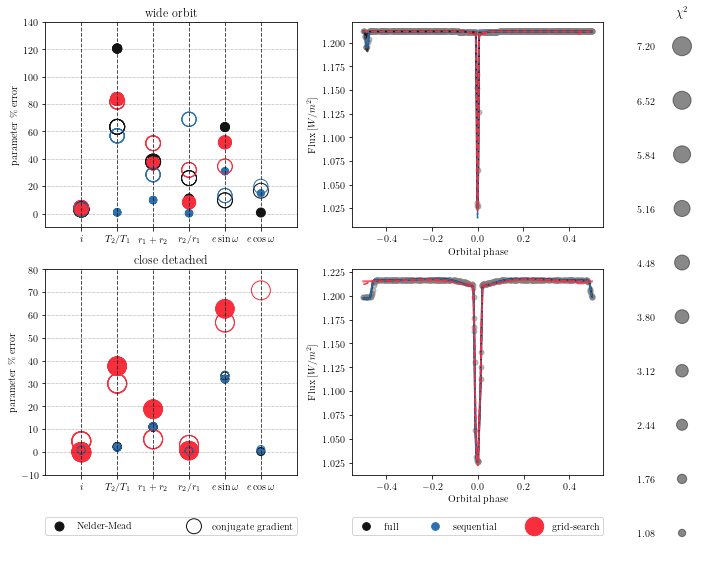

In [31]:
fig = plt.figure(figsize=(10,8))
gs = fig.add_gridspec(7, 7)
ax1 = fig.add_subplot(gs[0:3, 0:3])
ax2 = fig.add_subplot(gs[3:6, 0:3])
ax3 = fig.add_subplot(gs[0:3,3:6])
ax4 = fig.add_subplot(gs[3:6, 3:6])
ax5 = fig.add_subplot(gs[6,0:3])
ax6 = fig.add_subplot(gs[6,3:6])
ax7 = fig.add_subplot(gs[:,6])


scatter1, d1 = plot_solution(ax1, 'wide orbit', 
            ['$i$', '$T_{2}/T_{1}$', '$r_1+r_2$', '$r_2/r_1$', '$e\sin\omega$', '$e\cos\omega$'], 
            ['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'],
            we_true, we_nm_m2o, we_nm_m2s, we_nm_m2gs, we_cg_m2o, we_cg_m2s, we_cg_m2gs, mode='method', ylabel=True)
scatter2, d2 = plot_solution(ax2, 'close detached', 
            ['$i$', '$T_{2}/T_{1}$', '$r_1+r_2$', '$r_2/r_1$', '$e\sin\omega$', '$e\cos\omega$'], 
            ['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'],
            ce_true, ce_nm_m2o, ce_nm_m2s, ce_nm_m2gs, ce_cg_m2o, ce_cg_m2s, ce_cg_m2gs, mode='strategy')

plot_lc(ax3,we_true, we_nm_m2o, we_nm_m2s, we_nm_m2gs, we_cg_m2o, we_cg_m2s, we_cg_m2gs)
plot_lc(ax4,ce_true, ce_nm_m2o, ce_nm_m2s, ce_nm_m2gs, ce_cg_m2o, ce_cg_m2s, ce_cg_m2gs)

ax1.set_ylim(-10,140)
ax2.set_ylim(-10,80)
ax1.set_ylabel('parameter \% error')
ax2.set_ylabel('parameter \% error')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax5.legend(h1[:2],l1[:2], borderaxespad=0, mode='expand', ncol=2)
ax6.legend(h2[:3], l2[:3], borderaxespad=0, mode='expand', ncol=3)

ax5.axis("off")
ax6.axis("off")

s_all = d1['s'] + d2['s']
chi2 = np.array(s_all)/50
chi2_uni = np.linspace(chi2.min(), chi2.max(), 10)

ax7.set_xticks([])
ax7.set_yticks(np.linspace(chi2.min(), chi2.max(), 10))
ax7.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax7.tick_params(axis='y', length=0)
# ax7.yaxis.tick_right()

for axis in ['top','bottom','left','right']:
  ax7.spines[axis].set_linewidth(0)

ax7.scatter(np.ones(len(chi2_uni)),chi2_uni, marker='o', s=chi2_uni*50, facecolors = '#131313', edgecolors='#131313', alpha=0.5)
ax7.set_title(r'$\chi^2$')

# gs.tight_layout(fig)
fig.tight_layout()
# fig.savefig('figs/opimizing_strategies_methods.pdf')
fig.savefig('figs/opimizing_strategies_methods.png', dpi=300)
plt.show()